# Text segmentation using Hidden Markov Models

## Giovanni BENEDETTI DA ROSAS and Tarcisio DA SILVA BUENO

### Q.1. Give the value of the $\pi$ vector of the initial probabilities:

Since the decoding necessarily begins in the state 1:

$$\pi = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$$



### Q.2. : What is the probability to move from state 1 to state 2  What is the probability to remain in state 2? What is the lower/higher probability? Try to explain why.

Given the transition matrix $A$:

$$A = \begin{pmatrix} 0.999218078035812 & 0.000781921964187974 \\ 0 & 1 \end{pmatrix}$$

We can see that the probability to move from state 1 to state 2 is 0.000781921964187974 

And we can see that the probability to remain in state 2 is 1

The lower probability is to move from state 2 to state 1 is 0 since once in the body is impossible to go back to the header

The lower probability between $ a_{1,2} $ and $ a_{2,2} $ is $ a_{1,2} $ since if we are in the header there is only one character that is going to take us to the body, but once in the body all characters are going to stay in the body

### Q.3. What is the size of B?

There are N different characters and two different states, so the size of the matrix B is: $$(N,2).$$

In [34]:
import os
import glob
import numpy as np

In [35]:
ROOT = os.path.abspath(".")

DISTR_DIR = os.path.join(ROOT, "distribution")
RES_DIR = os.path.join(ROOT, "res")
DATA_DIR = os.path.join(ROOT, "dat")
SEGMENTED_DIR = os.path.join(ROOT, "segmented")


### Coding/Decoding Mails

In [36]:

# Iterate through files and load the text
def files_iter(data_dir, with_filename=False):
    files = glob.glob("{}/*.dat".format((data_dir)))

    if with_filename:
        for f in files:
            # Get the filename
            filename = f.split("\\")[-1].split(".")[0]
            # Return filename and associated text
            yield filename, open(f, "r").read()
    else:
        for f in files:
            yield open(f, "r").read()

In [37]:
# And we get a generator that will allow us to iterate through the mails
mail_iter = files_iter(DATA_DIR, with_filename=True)

### Distribution files

In [38]:

PERL_DIR = os.path.join(ROOT,'PerlScriptAndModel')

# Writing a function to get the probability data
def get_emission_prob(perl_dir):
    
    return np.loadtxt(os.path.join(perl_dir,))


In [39]:
# Inputs to the Viterbi function
trans = np.array([[0.999218078035812, 0.000781921964187974], [0, 1]])
emission_prob = get_emission_prob(os.path.join(PERL_DIR, "P.text"))
states = np.array([1, 2])
start_prob = np.array([1, 0])

### To implement:

In [40]:
# Viterbi function
def viterbi(obs, states, start_prob, trans, emission_prob):
    """
    Viterbi Algorithm Implementation

    Keyword arguments:
        - obs: sequence of observation
        - states: list of states
        - start_prob: vector of the initial probabilities
        - trans: transition matrix
        - emission_prob: emission probability matrix
    Returns:
        - seq: sequence of state
    """

    # Avoid underflow: use the logarithm !
    # Avoid 0 in logarithm: use a small constant !
    small = np.finfo(np.float64).tiny

    start_prob = np.log(start_prob + small)
    trans = np.log(trans + small)
    emission_prob = np.log(emission_prob + small)

    obs = [int(x) for x in obs.split("\n") if x != ""]

    # Number of observations
    T = len(obs)
    # Number of model states
    N = len(states)

    # Initialisation
    log_l = np.zeros((T, N))
    bcktr = np.zeros((T, N))

    # Viterbi algorithm
    # Forward loop:
    log_l[0, :] = start_prob + emission_prob[obs[0], :]

    for t in range(1, T):
        for s in range(N):
            log_l[t, s] = (
                np.max(log_l[t - 1, :] + trans[:, s]) + emission_prob[obs[t], s])
            bcktr[t, s] = np.argmax(log_l[t - 1, :] + trans[:, s] + emission_prob[obs[t], s])

    # Backward loop
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(log_l[-1, :])

    for i in range(T - 1, 0, -1):
        path[i - 1] = bcktr[i, path[i]]

    return [states[i] for i in path]

In [41]:
RES_DIR = os.path.join(ROOT,'res')

# Creating a directory to put the result of the viterbi function
if not os.path.exists(RES_DIR):
    os.mkdir(RES_DIR)
    
# Function that will write a viterbi path for a mail in a dedicated result file
def create_viterbi_path_file(mail_name, viterbi_path):
    with open('{}/{}_path.txt'.format(RES_DIR, mail_name), 'w') as f: 
        f.write(''.join([str(c) for c in viterbi_path]))   

In [42]:
# Using our generator, we get the mail names and data
for name_file, data in mail_iter:
    # Find out the viterbi path using viterbi
    viterbi_path =  viterbi(data, states, start_prob, trans, emission_prob)
    # Put it in the result file
    create_viterbi_path_file(name_file, viterbi_path)

In [43]:
def visualize_segmentation(mail_filename, visualized_mail_filename, path):
    ## @parameter mail_filename : Path to the mail on wich we try the algorithm.
    ## @parameter visualized_mail_filename : The path on which we write the mail with the v
    ## @parameter path : The sequence of 0 and 1 that the Viterbi algorithm returns.
    ## return: True if the header corresponds to the
    visu = open(visualized_mail_filename, "w")

    if mail_filename.endswith(".dat"):
        mail_filename = mail_filename[:-4] + ".txt"

    mail = open(mail_filename, "r")
    mail_content = mail.read()
    idx_split = len(path) - path.sum() - 1
    visu.write(mail_content[:idx_split])
    visu.write("\n===================== cut here\n")
    visu.write(mail_content[idx_split:])
    visu.close()
    mail.close()

    return idx_split

### Visualizing segmentation

In [44]:
# Writing a function getting the original mail, the result of viterbi, and applying the segmentation script
# Then putting the result
def segment_mail(mail_name, data_dir, res_dir):
    # Get the full path of the mail
    mail_filename = os.path.join(data_dir, f"{mail_name}.txt")
    # Get the full path of the result
    path_file = os.path.join(res_dir, f"{mail_name}_path.txt")

    # Read the result
    with open(path_file, "r") as f:
        path_read = f.read()
        path = [int(p) - 1 for p in path_read]

    path = np.array(path)

    # Execute the visualization script
    segmented_filename = os.path.join(SEGMENTED_DIR, f"{mail_name}_segmented.txt")
    idx_split = visualize_segmentation(mail_filename, segmented_filename, path)
    print(f"Mail {mail_name} segmented at index {idx_split} (out of {len(path)})")
    # Get the results
    formatted_mail_text = open(segmented_filename, "r").read()
    # Go through the resulting text until the cutting line
    cutting_line = "\n===================== cut here\n"

    if cutting_line in formatted_mail_text:
        # If this was not the last line, return the text cut in to parts: header and body
        header, body = formatted_mail_text.split(cutting_line, 1)
        return header, body
    else:
        # If not, it's just a header
        return formatted_mail_text, None

In [47]:
# Getting mails names
mail_names = [name for name, _ in files_iter(DATA_DIR, with_filename=True)]
print(mail_names)

if not os.path.exists(SEGMENTED_DIR):
    os.mkdir(SEGMENTED_DIR)

print(mail_names)

# Call the function and look at the result of segmentation
for mail_name in mail_names:
    header, body = segment_mail(mail_name, DATA_DIR, RES_DIR)
    print("Mail:", mail_name)
    print('Header:', header)
    print('###########################################################################################################')
    print('Body:', body)
    print('\n\n\n\n\n------------------------------\n\n\n\n\n')

['mail1', 'mail10', 'mail11', 'mail12', 'mail13', 'mail14', 'mail15', 'mail16', 'mail17', 'mail18', 'mail19', 'mail2', 'mail20', 'mail21', 'mail22', 'mail23', 'mail24', 'mail25', 'mail26', 'mail27', 'mail28', 'mail29', 'mail3', 'mail30', 'mail4', 'mail5', 'mail6', 'mail7', 'mail8', 'mail9']
['mail1', 'mail10', 'mail11', 'mail12', 'mail13', 'mail14', 'mail15', 'mail16', 'mail17', 'mail18', 'mail19', 'mail2', 'mail20', 'mail21', 'mail22', 'mail23', 'mail24', 'mail25', 'mail26', 'mail27', 'mail28', 'mail29', 'mail3', 'mail30', 'mail4', 'mail5', 'mail6', 'mail7', 'mail8', 'mail9']
Mail mail1 segmented at index 3795 (out of 5216)
Mail: mail1
Header: From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received:

### Q5 : How would you model the problem if you had to segment the mails in more than two parts (for example : header, body, signature) ? Draw a diagram of the corresponding Hidden Markov model and give an example of A matrix that would be suitable in this case.



$$A = \begin{pmatrix} a_{11} & a_{12} & a_{13} \\ 0 & a_{22} & a_{23} \\ 0 & 0 & 1 \end{pmatrix}$$

It is evident that transitions from the body to either the header or the signature are impossible, and similarly, transitions from the signature to either the header or the body are impossible.

Again, the initial probability vector would be:

$$\pi = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}$$


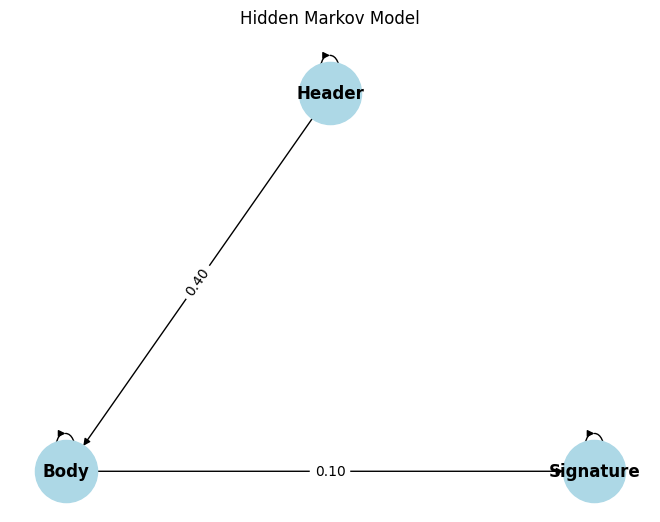

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the states
states = ['Body', 'Header', 'Signature']

# Define the transition probabilities
a_11 = 0.7
a_12 = 0.2
a_13 = 0.1
a_22 = 0.6
a_23 = 0.4

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each state
G.add_nodes_from(states)

# Add edges representing transitions between states
transitions = [('Body', 'Body', a_11), ('Body', 'Signature', a_13),
               ('Header', 'Header', a_22), ('Header', 'Body', 1 - a_22),  # Rest of the probability to Body
               ('Signature', 'Signature', 1)]  # No transitions from Signature except to itself

# Add edges to the graph with labels
for source, target, probability in transitions:
    G.add_edge(source, target, label=f'{probability:.2f}')

# Set node positions for better visualization
pos = {'Body': (1, 1), 'Header': (2, 2), 'Signature': (3, 1)}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold')

# Draw edge labels (transition probabilities)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the graph
plt.title('Hidden Markov Model')
plt.axis('off')
plt.show()


### Q6 : How would you model the problem of separating the portions of mail included, knowing that they always start with the character ">". Draw a diagram of the corresponding Hidden Markov model.